In [1]:
from __future__ import division

import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris

In [2]:
%matplotlib inline

In [3]:
iris = load_iris()
x_iris = iris['data']
y_iris = map(lambda x: np.array([1 if i == x else 0 for i in range(3)]),
        iris['target'])
y_iris = np.array(y_iris)

In [4]:
sigmoid = np.vectorize(lambda x: 1.0/(1.0+np.exp(-x)))
sig = lambda x: 1.0/(1.0+np.exp(-x))
sig_d = lambda x: sig(x) * (1 - sig(x))
sigmoid_d = np.vectorize(lambda x: sig(x) * (1 - sig(x)))

tanh_d = lambda x: 1 - np.square(np.tanh(x))

In [5]:
def log_loss(y, yhat):
    return np.sum(-(y*np.log(yhat) + (1 - y)*np.log(1 - yhat)))

In [75]:
class neural_network:
    
    def __init__(self, sizes, activation = sigmoid, act_d = sigmoid_d):
        '''
        one required arguement: a list with the layer sizes
        can be used for classification or regression
        '''
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(x) for x in sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.a = [np.zeros(x) for x in sizes]
        self.a_vec = []
        self.activation = activation
        self.act_d = act_d
        self.z = [np.zeros(x) for x in sizes[1:]]
        self.z_vec = []
        
        
    def predict(self,x):
        self.a_vec = []
        self.z_vec = []
        self.a_vec = [x]
        m = x.shape[0]
        biases = [np.matlib.repmat(b, m, 1) for b in self.biases]
        for w, b in zip(self.weights, biases):
            z = np.dot(w, x.T).T + b
            self.z_vec.append(z)
            x = sig(z)
            self.a_vec.append(x)
        
        return x      
                

    def back_prop(self, x, y):
        '''
        vectorized back propigation
        '''
        nabla_w = [None for l in self.weights]
        nabla_b = [None for l in self.weights]
        deltas = [None for l in self.sizes]
        yhat = self.predict(x)
        deltas[-1] = yhat - y
        for l in range(1, self.num_layers - 1)[::-1]:
            w = self.weights[l]
            a = self.a_vec[l]
            z = self.z_vec[l-1]
            deltas[l] = (np.dot(w.T, deltas[l+1].T) * sig_d(z).T).T
        for l in range(0, self.num_layers-1):
            nabla_w[l] =  np.dot(deltas[l+1].T, self.a_vec[l])
            nabla_b[l] = deltas[l+1]
        return nabla_w, [b.sum(axis = 0) for b in nabla_b]
    

        
        
    def gradient_descent(self, x, y, lr, Lambda):
        '''
        vectorized gradient descent function.
        performas a single gradient descent update on the weights and biases
        '''
        m = len(x)
        delta_weights, delta_biases = self.back_prop(x, y)          
        
        self.weights = [w - (lr * wg/m + Lambda * w) for
                        wg, w in zip(delta_weights, self.weights)]
        self.biases = [b - lr * bg/m for bg, b
                        in zip(delta_biases, self.biases)]
        
    
    def fit(self, x, y, batch_size, test_x, test_y,
            learning_rate = 0.01, epochs = 1,
            Lambda = 1e-4, return_cost = False): 
        '''
        train the neural network using minibatch gradient descent
        '''
        if return_cost:
            cost = []
        for e in xrange(epochs):
#             if e % 10 == 0:
            print e
            # create mini batches for minibatch gradient descent
            m = len(x)
            index = np.array(range(m))
            np.random.shuffle(index)
            batch_size = 8
            num_batches = round(m/batch_size,0)
            batches = np.array_split(index, num_batches)
            for batch in batches:
                self.gradient_descent(x[batch], y[batch],
                                      learning_rate, Lambda)
            if return_cost:
                cost.append(log_loss(test_y, self.predict(test_x)))
        
        if return_cost:
            return cost

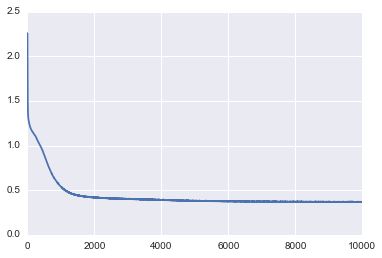

In [38]:
plt.plot(np.array(cost)/len(x_iris))

In [16]:
import time

In [40]:
t0 = time.time()

my_nn = neural_network([4,8,3])
cost = my_nn.fit(x_iris, y_iris, batch_size = 8,
                 epochs = 10000, return_cost = True)

t1 = time.time()
t1 - t0

16.192999839782715

In [21]:
t0 = time.time()

my_nn = neural_network([4,8,3])
my_nn.fit(x_iris, y_iris, batch_size = 8,
                 epochs = 1000)

t1 = time.time()
t1 - t0

1.4649999141693115

In [19]:
t0 = time.time()
cost = []
my_nn = neural_network([4,8,3])
for j in xrange(1000):
    my_nn.gradient_descent(x_iris, y_iris, 0.01)
    cost.append(log_loss(y_iris, my_nn.predict_vec(x_iris)))
    
t1 = time.time()
t1 - t0

16.092999935150146

In [20]:
t0 = time.time()
cost = []
my_nn = neural_network([4,8,3])
for j in xrange(1000):
    my_nn.gradient_descent(x_iris, y_iris, 0.01)
    cost.append(log_loss(y_iris, my_nn.predict(x_iris)))
    
t1 = time.time()
t1 - t0

22.562000036239624

In [41]:
import pandas as pd

In [42]:
minst_df = pd.read_csv('C:/Users/jay.swinney/Desktop/minst.csv')
minst = minst_df.values[:,1:]
minst_lables = minst_df['label']

In [48]:
from sklearn.cross_validation import train_test_split

In [69]:
minst_train, minst_test, label_train, label_test = train_test_split(
    minst, minst_lables, test_size = 0.2)

In [50]:
minst.shape

(42000L, 784L)

In [63]:
def expand_y(y):
    out = np.zeros(10)
    out[y] = 1
    return out

expand = np.vectorize(expand_y)

In [70]:
label_test = np.array(map(expand_y,label_test))
label_train = np.array(map(expand_y,label_train))

In [77]:
t0 = time.time()

my_nn = neural_network([784,2*784, 10])
cost = my_nn.fit(minst_train, label_train, batch_size = 2000,
                 epochs = 10, return_cost = True,
                 test_x = minst_test, test_y = label_test)

t1 = time.time()
t1 - t0

0
1
2
3
4
5
6
7
8
9


1689.1000001430511

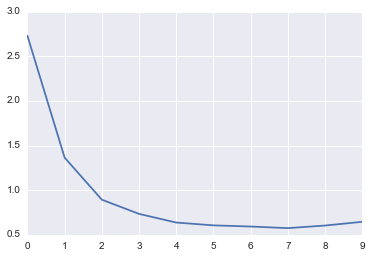

In [78]:
plt.plot(np.array(cost)/len(label_test))